In [36]:
import numpy as np

import torch, torch.mps
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn

from tqdm.notebook import trange
import rich.jupyter as r
from rich import pretty
pretty.install()

seaborn.set()
r.print("TORCH version: ", torch.__version__)

TORCH version:  2.0.0

In [2]:
%run aux.ipynb

device = detect_and_init_device()  # type: ignore
r.print("Device:", device)

dtype = torch.float32

Device: mps

## XOR Problem

### Data

In [3]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        super().__init__()
        self.size = size
        self.std = std
        self.data = torch.randint(low=0, high=2, size=(size, 2), dtype=dtype)
        self.label = (self.data.sum(dim=1)==1).to(torch.long)
        self.data += std * torch.randn(self.data.shape)

    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [4]:
dataset = XORDataset(size=200)

r.print("dataset length", len(dataset))
r.print("first point", dataset[0])

dataset length 200

first point
(tensor([ 1.1622, -0.1815]), tensor(1))

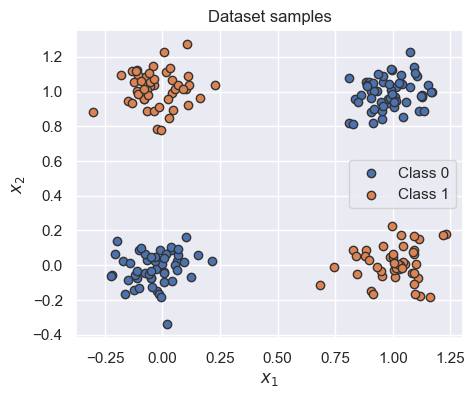

In [5]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(5,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

visualize_samples(dataset.data, dataset.label)

In [13]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [15]:
r.print("Random batch:\n", next(iter(data_loader)))

Random batch:

[
    tensor([[-0.1223, -0.1446],
        [-0.1001, -0.1294],
        [ 0.0177, -0.3403],
        [ 0.0677,  1.0362],
        [ 1.0033, -0.0250],
        [-0.1311,  0.9325],
        [ 1.0924, -0.1068],
        [ 1.2184,  0.1730]]),
    tensor([0, 0, 0, 1, 1, 1, 1, 1])
]

### Idiomatic solution

In [7]:
class SimpleClassifier(nn.Module):

    def __init__(self, no_inputs, no_hidden, no_outputs):
        super().__init__()
        self.linear1 = nn.Linear(no_inputs, no_hidden)
        self.act = nn.Tanh()
        self.linear2 = nn.Linear(no_hidden, no_outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = self.act(x)
        x = self.linear2(x)
        return x

In [48]:
model = SimpleClassifier(2, 4, 1)
model

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [49]:
for name, param in model.named_parameters():
    r.print(name, ": ", param)

linear1.weight :  Parameter containing:
tensor([[-0.3011,  0.5359],
        [-0.6617, -0.3084],
        [-0.4780,  0.6134],
        [-0.4193, -0.0953]], requires_grad=True)

linear1.bias :  Parameter containing:
tensor([-0.0445,  0.4713, -0.6426, -0.3958], requires_grad=True)

linear2.weight :  Parameter containing:
tensor([[-0.3289,  0.1975, -0.3430, -0.3784]], requires_grad=True)

linear2.bias :  Parameter containing:
tensor([-0.2417], requires_grad=True)

In [50]:
loss_module = nn.BCEWithLogitsLoss()

In [51]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [52]:
dataset = XORDataset(size=2500)
data_loader = data.DataLoader(dataset, batch_size=128, shuffle=True)

In [53]:
def train_classifier(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()

    loss_trend = np.nan * np.ones(num_epochs)
    # Training loop
    for epoch in trange(num_epochs):
        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 3: Calculate and log the loss
            loss = loss_module(preds, data_labels.float())

            loss_trend[epoch] = loss.item()

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

    return loss_trend

In [54]:
model = model.to(device)
trend = train_classifier(model, optimizer, data_loader, loss_module, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

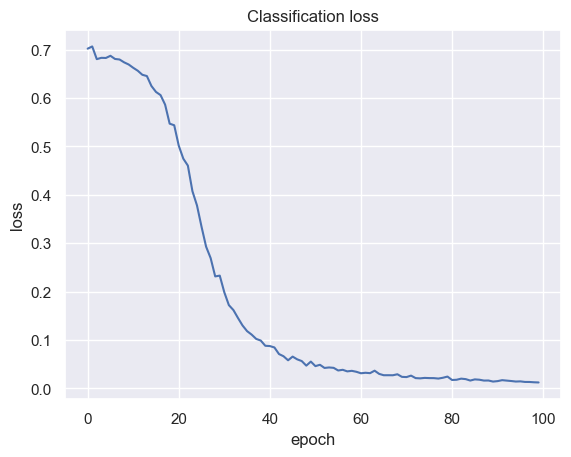

In [58]:
def visualize_training(trend):
    plt.plot(trend)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Classification loss")

visualize_training(trend)

In [44]:
test_dataset = XORDataset(size=500)
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [45]:
def test_classifier(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
            pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    return acc.item()

In [46]:
acc = test_classifier(model, test_data_loader)
r.print("accuracy", acc)

accuracy 1.0

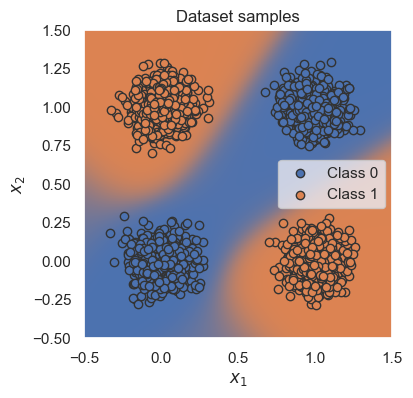

In [41]:
@torch.no_grad() # Decorator, same effect as "with torch.no_grad(): ..." over the whole function.
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(5,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)

visualize_classification(model, dataset.data, dataset.label)

### Solution using *raw* `torch`


In [26]:
x = torch.arange(3, dtype=dtype)
x = x.to(device)
x.requires_grad_(True)

tensor([0., 1., 2.], device='mps:0', requires_grad=True)

In [27]:
a = x + 2
b = a**2
c = b + 3
y = c.mean()

In [28]:
y.backward()
x.grad

tensor([1.3333, 2.0000, 2.6667], device='mps:0')

### Saving and loading a model

In [23]:
r.print("Saved parameters\n", model.state_dict())

Saved parameters

OrderedDict([('linear1.weight', tensor([[-0.7706, -0.3651],
        [-2.3088, -2.2699],
        [ 3.2266, -2.2819],
        [ 2.3575, -3.2386]], device='mps:0')), ('linear1.bias', tensor([ 0.8397,  0.4817,  0.8757, -0.9018], 
device='mps:0')), ('linear2.weight', tensor([[ 1.0061, -3.3983, -4.1581,  4.2752]], device='mps:0')), 
('linear2.bias', tensor([1.0981], device='mps:0'))])

In [22]:
torch.save(model.state_dict(), "t2.pt")

In [24]:
loaded_parameters = torch.load("t2.pt")
r.print("Loaded parameters\n", loaded_parameters)

Loaded parameters

OrderedDict([('linear1.weight', tensor([[-0.7706, -0.3651],
        [-2.3088, -2.2699],
        [ 3.2266, -2.2819],
        [ 2.3575, -3.2386]], device='mps:0')), ('linear1.bias', tensor([ 0.8397,  0.4817,  0.8757, -0.9018], 
device='mps:0')), ('linear2.weight', tensor([[ 1.0061, -3.3983, -4.1581,  4.2752]], device='mps:0')), 
('linear2.bias', tensor([1.0981], device='mps:0'))])

In [26]:
loaded_model = SimpleClassifier(no_inputs=2, no_hidden=4, no_outputs=1)
loaded_model.load_state_dict(loaded_parameters)

<All keys matched successfully>